## Прогноз вероятности неврологических проявлений при болезни Вильсона-Коновалова. Линейная логистическая регрессия

* Импорт библиотек
* Чтение данных
* Пропуски в данных
* Группы признаков
* Отбор признаков для модели
* Оптимизация параметров и оценка качества моделей
* Выводы

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 70)   # Настройка отображения данных в Jupyter notebook
pd.set_option('display.max_rows', 100)
pd.set_option('precision', 3)

%pylab inline
# Visualization and Graphics
%matplotlib inline
import matplotlib.pyplot as plt

# !conda install seaborn 
import seaborn as sns
plt.rcParams['figure.figsize'] = (7,7)   # (8,6)

#!pip install ggplot
matplotlib.style.use('ggplot')       # Use ggplot style plots

Populating the interactive namespace from numpy and matplotlib


### Чтение данных

In [2]:
# Чтение данных из сохранённого файла
df_ext = pd.DataFrame()
df_ext = pd.read_csv('./data/Wilson_ext.csv', sep=';', encoding='utf-8') 
print(df_ext.columns)

Index(['TargetHead', 'TargetHeadRelativeMax', 'Sex', 'Sex M/F', 'BMI',
       'Height', 'Mass', 'BMI_scaled', 'Height_scaled', 'Mass_scaled', 'KKF',
       'Cirrhosis', 'ChildPugh', 'Advanced', 'Activity', 'DebutAge',
       'DebutAge_scaled', 'DebutLiver', 'DebutNeuro', 'DebutKidney',
       'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez',
       'DebutOther', 'F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3', 'PAI_1', 'FGB',
       'MTHFR_677', 'MTHFR_1298', 'F2__1', 'F5__1', 'F7__1', 'F13__1',
       'ITGA2__1', 'ITGB3__1', 'PAI_1__1', 'FGB__1', 'MTHFR_677__1',
       'MTHFR_1298__1', 'F2__2', 'F5__2', 'F7__2', 'F13__2', 'ITGA2__2',
       'ITGB3__2', 'PAI_1__2', 'FGB__2', 'MTHFR_677__2', 'MTHFR_1298__2',
       'F2_GA', 'F2_GG', 'F5_GA', 'F5_GG', 'F7_GA', 'F7_GG', 'F13_GG',
       'F13_GT', 'F13_TT', 'ITGA2_CC', 'ITGA2_CT', 'ITGA2_TT', 'ITGB3_TC',
       'ITGB3_TT', 'PAI_1_4G4G', 'PAI_1_5G4G', 'PAI_1_5G5G', 'FGB_AA',
       'FGB_GA', 'FGB_GG', 'MTHFR_677_CC', 'MTHFR_

### Пропуски в данных
Заполним пропуски **средними значениями**. Это удобно для выбранного алгоритма.

In [3]:
for c in df_ext.columns:
    number_of_na = np.sum(df_ext[c].isna())            # Needs Pandas 22.0 or higher
    if number_of_na > 0:
        print(c, number_of_na, df_ext[c].mean())

df = df_ext.fillna(df_ext.mean())

print( df_ext[['TargetHeadRelativeMax', 'BMI']].fillna(df_ext.mean()).head(8) )

TargetHeadRelativeMax 71 0.5384615384615384
BMI 1 22.89808806306615
Height 3 1.7483950617283952
Mass 3 70.19135802469135
BMI_scaled 1 -0.025477984233461776
Height_scaled 3 -0.016049382716049512
Mass_scaled 3 0.012757201646090528
KKF 1 0.8072289156626506
   TargetHeadRelativeMax     BMI
0                  0.538  24.220
1                  0.538  19.493
2                  0.538  21.605
3                  0.000  18.145
4                  1.000  21.778
5                  0.538  21.295
6                  0.538  17.631
7                  0.538  22.898


### Группы признаков

Группы выделены в соответствии со смыслом данных, форматом их представления, <br> планируемой логикой их обработки и использования.

- `target_features`, 
- `relatives_features`, 
- `sex_features`, `sex_features_cat`, 
- `bmi_features`, `bmi_features_scaled`,
- `symptom_features`, `cirrhosis_features`, 
- `debut_age_features`, `debut_age_features_scaled`,
- `debut_organ_features`,
- `genetic_features`, `genetic_features__1`, `genetic_features__2`, `genetic_features__dummy`, `genetic_risk_features`
- `exclude_features`

In [4]:
target_features        = ['TargetHead']                                                    # TargetHead = ifelse(Target == 3, 1, 0)
relatives_features     = ['TargetHeadRelativeMax']                                         # Наихудший диагноз у родсттвенников
sex_features           = ['Sex']                                                           # Пол
bmi_features           = ['BMI', 'Height', 'Mass']                                         # Идекс массы тела, Рост, Вес
symptom_features       = ['KKF']                                                           # Симптом: Кольца Кайзера — Флейшера
cirrhosis_features     = ['Cirrhosis', 'ChildPugh', 'Advanced', 'Activity']                # Цирроз: Стадия. Активность (динамика).
debut_age_features     = ['DebutAge']                                                      # Дебют заболвания: возраст
debut_organ_features   = ['DebutLiver', 'DebutNeuro', 'DebutKidney', 'DebutEndocr',        # Дебют заболвания: что выявили
                          'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther']
genetic_features       = ['F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3',                       # Генетические признаки 
                          'PAI_1', 'FGB', 'MTHFR_677', 'MTHFR_1298']
exclude_features       = ['Target', 'TargetRelativeMax']                                   # Исключить из данных
exclude_model_features = ['FamilyID', 'DebutNeuro'] + exclude_features                     # Исключить из модели

In [5]:
num_features_to_scale     = ['BMI','Height','Mass','DebutAge']                             # Числовые показатели
num_features_scaled       = ['BMI_scaled','Height_scaled','Mass_scaled','DebutAge_scaled']

# Группировка
bmi_features_scaled       = ['BMI_scaled','Height_scaled','Mass_scaled']
debut_age_features_scaled = ['DebutAge_scaled']

In [6]:
sex_features_cat = ['Sex M/F']

In [7]:
genetic_features__dummy = ['F2_GA', 'F2_GG', 'F5_GA', 'F5_GG', 'F7_GA', 'F7_GG', 
                           'F13_GG', 'F13_GT', 'F13_TT', 'ITGA2_CC', 'ITGA2_CT', 'ITGA2_TT', 
                           'ITGB3_TC', 'ITGB3_TT', 'PAI_1_4G4G', 'PAI_1_5G4G', 'PAI_1_5G5G', 
                           'FGB_AA', 'FGB_GA', 'FGB_GG', 'MTHFR_677_CC', 'MTHFR_677_CT', 'MTHFR_677_TT', 
                           'MTHFR_1298_AA', 'MTHFR_1298_AC', 'MTHFR_1298_CC']

genetic_features__1 = ['F2__1', 'F5__1', 'F7__1', 'F13__1', 'ITGA2__1', 'ITGB3__1', 
                       'PAI_1__1', 'FGB__1', 'MTHFR_677__1', 'MTHFR_1298__1']

genetic_features__2 = ['F2__2', 'F5__2', 'F7__2', 'F13__2', 'ITGA2__2', 'ITGB3__2', 
                       'PAI_1__2', 'FGB__2', 'MTHFR_677__2', 'MTHFR_1298__2']

genetic_risk_features = ['GenRisk__1', 'GenRisk__2', 'GenProtect__1', 'GenProtect__2']

In [8]:
def combine_features(all_feat_list, exclude_features):
    combined_list = list()
    for sublist in all_feat_list:
        for item in sublist:
            combined_list.append(item)
    combined_list = [x for x in combined_list if x not in exclude_features]
    return(combined_list)

In [9]:
data_features = combine_features([ target_features, relatives_features, sex_features, bmi_features, symptom_features, 
                                   cirrhosis_features, debut_age_features, debut_organ_features, genetic_features ],
                                 exclude_features)

print(data_features)

['TargetHead', 'TargetHeadRelativeMax', 'Sex', 'BMI', 'Height', 'Mass', 'KKF', 'Cirrhosis', 'ChildPugh', 'Advanced', 'Activity', 'DebutAge', 'DebutLiver', 'DebutNeuro', 'DebutKidney', 'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther', 'F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3', 'PAI_1', 'FGB', 'MTHFR_677', 'MTHFR_1298']


In [10]:
data_features_ext = combine_features(
                       [target_features, relatives_features, 
                        sex_features, sex_features_cat, 
                        bmi_features, bmi_features_scaled,
                        symptom_features, 
                        cirrhosis_features, 
                        debut_age_features, debut_age_features_scaled,
                        debut_organ_features,
                        genetic_features, genetic_features__1, genetic_features__2, genetic_features__dummy, 
                        genetic_risk_features ],
                       exclude_model_features)
print(data_features_ext)

['TargetHead', 'TargetHeadRelativeMax', 'Sex', 'Sex M/F', 'BMI', 'Height', 'Mass', 'BMI_scaled', 'Height_scaled', 'Mass_scaled', 'KKF', 'Cirrhosis', 'ChildPugh', 'Advanced', 'Activity', 'DebutAge', 'DebutAge_scaled', 'DebutLiver', 'DebutKidney', 'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther', 'F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3', 'PAI_1', 'FGB', 'MTHFR_677', 'MTHFR_1298', 'F2__1', 'F5__1', 'F7__1', 'F13__1', 'ITGA2__1', 'ITGB3__1', 'PAI_1__1', 'FGB__1', 'MTHFR_677__1', 'MTHFR_1298__1', 'F2__2', 'F5__2', 'F7__2', 'F13__2', 'ITGA2__2', 'ITGB3__2', 'PAI_1__2', 'FGB__2', 'MTHFR_677__2', 'MTHFR_1298__2', 'F2_GA', 'F2_GG', 'F5_GA', 'F5_GG', 'F7_GA', 'F7_GG', 'F13_GG', 'F13_GT', 'F13_TT', 'ITGA2_CC', 'ITGA2_CT', 'ITGA2_TT', 'ITGB3_TC', 'ITGB3_TT', 'PAI_1_4G4G', 'PAI_1_5G4G', 'PAI_1_5G5G', 'FGB_AA', 'FGB_GA', 'FGB_GG', 'MTHFR_677_CC', 'MTHFR_677_CT', 'MTHFR_677_TT', 'MTHFR_1298_AA', 'MTHFR_1298_AC', 'MTHFR_1298_CC', 'GenRisk__1', 'GenRisk__2', 'GenPro

### Отбор признаков для модели

In [11]:
# Без генетических факторов: 'GenRisk__2', 'GenProtect__2'
model_0_features = combine_features(
                       [
                        # target_features, 
                        relatives_features, 
                        sex_features, #sex_features_cat, 
                        # bmi_features, 
                        [bmi_features_scaled[0]],
                        symptom_features, 
                        [cirrhosis_features[0],cirrhosis_features[3]], 
                        # debut_age_features,
                        debut_age_features_scaled,
                        debut_organ_features
                        # genetic_features, genetic_features__1, genetic_features__2, genetic_features__dummy, 
                        #[genetic_risk_features[1],genetic_risk_features[3]]
                        ],
                       exclude_model_features)
print(model_0_features)

['TargetHeadRelativeMax', 'Sex', 'BMI_scaled', 'KKF', 'Cirrhosis', 'Activity', 'DebutAge_scaled', 'DebutLiver', 'DebutKidney', 'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther']


In [12]:
# Модель с генетическими факторами: 'GenRisk__2', 'GenProtect__2'
model_features = combine_features(
                       [
                        # target_features, 
                        relatives_features, 
                        sex_features, #sex_features_cat, 
                        # bmi_features, 
                        [bmi_features_scaled[0]],
                        symptom_features, 
                        [cirrhosis_features[0],cirrhosis_features[3]], 
                        # debut_age_features,
                        debut_age_features_scaled,
                        debut_organ_features,
                        # genetic_features, genetic_features__1, genetic_features__2, genetic_features__dummy, 
                        [genetic_risk_features[1],genetic_risk_features[3]]
                        ],
                       exclude_model_features)
print(model_features)

['TargetHeadRelativeMax', 'Sex', 'BMI_scaled', 'KKF', 'Cirrhosis', 'Activity', 'DebutAge_scaled', 'DebutLiver', 'DebutKidney', 'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther', 'GenRisk__2', 'GenProtect__2']


In [13]:
X   = df[model_features]
X_0 = df[model_0_features]
y   = np.array(df[target_features]).T[0]

In [14]:
y

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], dtype=int64)

### Оптимизация параметров и оценка качества моделей

In [15]:
from sklearn.linear_model    import LinearRegression, LogisticRegression, LassoCV, Lasso

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [26]:
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# param_grid = { 'C': np.logspace(-6, 2, 200) }
param_grid = { 'C': np.logspace(-6, 2, 17) }
param_grid = { 'C': np.logspace(-6, 2, 25) }
param_grid = { 'C': np.logspace(-6, 2, 33) }
param_grid = { 'C': np.logspace(-6, 2, 49) }
param_grid = { 'C': np.logspace(-6, 2, 65) }
param_grid = { 'C': np.logspace(-6, 2, 97) }
param_grid = { 'C': np.logspace(-6, 2, 129) }
#param_grid = { 'C': np.logspace(-6, 2, 193) }
#param_grid

In [27]:
%%time

grid_searcher = GridSearchCV(                     # For model with genetic features
    estimator = LogisticRegression(random_state=42, penalty = 'l1'),
    param_grid = param_grid,
    scoring = 'roc_auc',
    cv = kfold, n_jobs=1)

grid_searcher.fit(X, y)
print('grid_searcher.fit(X, y) best score:', grid_searcher.best_score_, grid_searcher.best_params_)

grid_searcher.fit(X, y) best score: 0.802976190476 {'C': 0.36517412725483772}
Wall time: 9.54 s


In [28]:
%%time
grid_searcher_0 = GridSearchCV(                  # For model without genetic features
    estimator=LogisticRegression(random_state=42, penalty = 'l1'),
    param_grid= param_grid,
    scoring = 'roc_auc',
    cv=kfold, n_jobs=1)

grid_searcher_0.fit(X_0, y)
print('grid_searcher_0.fit(X_0, y) best score:', grid_searcher_0.best_score_, grid_searcher_0.best_params_)

grid_searcher_0.fit(X_0, y) best score: 0.783234126984 {'C': 0.86596432336006535}
Wall time: 9.28 s


#### Зависимость ROC AUC от параметра регуляризации C = $1/\gamma$

In [29]:
import warnings
warnings.filterwarnings('ignore')

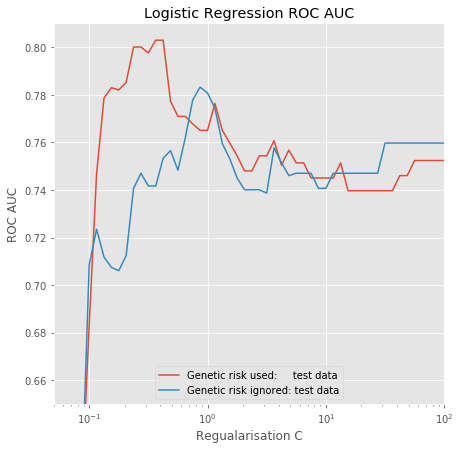

In [30]:
results   = pd.DataFrame(grid_searcher.cv_results_)
results_0 = pd.DataFrame(grid_searcher_0.cv_results_)

#plt.plot(results['param_C'],   results['mean_train_score'],   label= 'X:  train ROC AUC')
plt.semilogx(results['param_C'],   results['mean_test_score'],    label= 'Genetic risk used:     test data')
#plt.plot(results_0['param_C'], results_0['mean_train_score'], label= 'X0: train ROC AUC')
plt.semilogx(results_0['param_C'], results_0['mean_test_score'],  label= 'Genetic risk ignored: test data')
plt.legend(loc='lower center');
plt.title('Logistic Regression ROC AUC') 
ymin, ymax = (0.65, 0.81)
plt.ylim( (ymin, ymax) )
xmin, xmax = (0.05, 100)
plt.xlim( (xmin, xmax) )
plt.xlabel('Regualarisation C')
plt.ylabel('ROC AUC')

#results_0   #.describe().T

#### Зависимость коэффцицентов модели от параметра регуляризации C = $1/\gamma$

Оптимизируем $C \cdot \sum  LogLoss(i) + \sum |w_i|$. 
<br> - Большая $C$: доминирует $\sum LogLoss$ - слабая регуляризация.
<br> - Малая $C$: доминирует $\sum |w_i|$ - сильная регуляризация.



Веса признаков для модели LogisticRegression
с генетическими факторами риска
1. GenRisk__2           	0.426437
2. DebutAge_scaled      	0.048978
15. Activity             	-0.104285
16. Sex                  	-0.250381
17. DebutLiver           	-1.405609


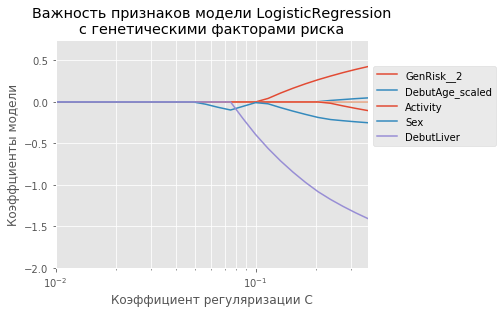


Веса признаков для модели LogisticRegression
без генетических факторов риска
1. TargetHeadRelativeMax 	0.988504
2. KKF                  	0.887699
3. Cirrhosis            	0.267092
4. DebutAge_scaled      	0.128967
13. Sex                  	-0.451326
14. Activity             	-0.486426
15. DebutLiver           	-1.549851


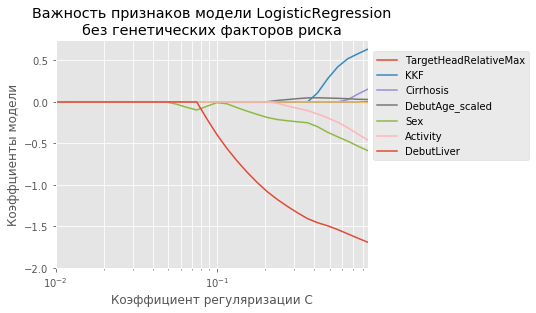

In [34]:
def report_importances(grid_searcher, param_grid, model_features, model_type_name, features_set_name):
    
    # -----------------------------------------------------
    # Print featires of the best model
    # -----------------------------------------------------
    importances = grid_searcher.best_estimator_.coef_[0]

    indices_abs = np.argsort(np.abs(importances))[::-1]    # Absolute importance
    indices_ord = np.argsort(importances)[::-1]            # rank importance

    #print("Feature importance:")
    #indices = indices_abs
    #for f in range(len(model_features)):                 #  range(X.shape[1]):
    #    if np.abs(importances[indices[f]])>0:
    #        print("%d. %-20s \t%f" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

    print("\nВеса признаков для модели " + model_type_name + "\n" + features_set_name)
    indices = indices_ord
    for f in range(len(model_features)):                 #  range(X.shape[1]):
        if np.abs(importances[indices[f]])>0:
            print("%d. %-20s \t%f" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

    # -----------------------------------------------------
    # Graphics
    # -----------------------------------------------------
    coefs   = []
    estimator=LogisticRegression(random_state=42, penalty = 'l1')
    for C in param_grid["C"]:
        params = {"C":C}
        estimator.set_params(**params)
        estimator.fit(X, y)
        coef_ = estimator.coef_[0]
        coefs.append(coef_)

    ax = plt.gca()
    for f in range(len(model_features)):
        i = indices_ord[f]
        feature = model_features[i]
        feature_data = np.array(coefs).T.tolist()[i]
        if np.abs(importances[indices[f]])>0:
            ax.plot(param_grid["C"], feature_data, label=feature)
        else:
            ax.plot(param_grid["C"], feature_data)

    ax.set_prop_cycle(cycler('color', 
                          ['b', 'r', 'g', 'c', 'k', 'y', 'm']))

    ax.set_xscale('log')
    plt.xlabel('Коэффициент регуляризации C')
    plt.ylabel('Коэффциенты модели')
    plt.title('Важность признаков модели ' + model_type_name + '\n' + features_set_name)
    ax.set_xlim(left=0.01, right=grid_searcher.best_params_["C"])   # 100)
    ax.set_ylim(bottom=-2, top=0.75)   # 100)

    # Put a legend to the right: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    box = ax.get_position()      # print("box: ", box)
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height * 0.6]) # Shrink current axis to 80% (x) and 60% (y).
    ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.71))

    ax.minorticks_on             # Grid at minor ticks
    ax.grid(True, which='both')

    plt.show();
# -----------------------------------------------------------------

report_importances(grid_searcher, param_grid, model_features,     "LogisticRegression", "с генетическими факторами риска")
report_importances(grid_searcher_0, param_grid, model_0_features, "LogisticRegression",  "без генетических факторов риска")

### Leave-one-out cross-validation

In [35]:
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut, KFold, ShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc

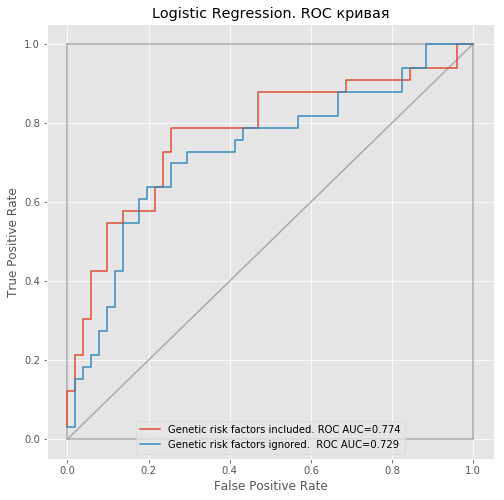

In [36]:
name  = "Genetic risk factors included."
clf = LogisticRegression(random_state=42, penalty = 'l1', C=0.38311868495572848) 
cv_predictions = cross_val_predict(clf, X, y,
                                       method='predict_proba',
                                       cv=LeaveOneOut() ) #  cv=10)


name_0  = "Genetic risk factors ignored."
clf_0 = LogisticRegression(random_state=42, penalty = 'l1', C=1)
cv_predictions_0 = cross_val_predict(clf_0, X_0, y,
                                       method='predict_proba',
                                       cv=LeaveOneOut() ) #  cv=10)

fpr,   tpr,   thresh = roc_curve(y, cv_predictions[: ,1])
fpr_0, tpr_0, thresh = roc_curve(y, cv_predictions_0[: ,1])
    
figure(figsize=(8,8))
plt.plot([0,1],[0,1],color='darkgray')
plt.plot([0,0],[0,1],color='darkgray')
plt.plot([0,1],[0,0],color='darkgray')
plt.plot([0,1],[1,1],color='darkgray')
plt.plot([1,1],[0,1],color='darkgray')

plt.plot(fpr,   tpr,   label= name  
                              + ' ROC AUC=' + str( round(auc(fpr,   tpr  )*1000)/1000. ) )
plt.plot(fpr_0, tpr_0, label= name_0
                              + '  ROC AUC=' + str( round(auc(fpr_0, tpr_0)*1000)/1000. ) )

xlabel('False Positive Rate')
ylabel('True Positive Rate')
title('Logistic Regression. ROC кривая')
legend(loc='lower center');

plt.savefig('LogRegression.png', bbox_inches='tight')

### Выводы
* Комбинированный генетический фактор позволил уточнить ROC AUC: с 0.729 до 0.774. <br> Статистическая достоверность не оценивалась.
* При малых значениях параметра регяляризации $C = 1/\gamma$, лучшее ROC AUC -- у предсказателя, использующего генетические факторы риска, а при больших сравнение неоднозначно: лучше то один, то другой предсказатель.
* Признаки моделей LogisticRegression с наибольшей ROC AUC:
    * с использованием генетических факторов риска: <br> GenRisk\_\_2 (0.43), DebutAge_scaled (0.05), Activity (-0.1), Sex (-0.25),  DebutLiver (-1.41)
    * без использования генетических факторов риска: <br>  TargetHeadRelativeMax (0.99), KKF (0.89), Cirrhosis (0.27), DebutAge_scaled (0.13), Sex (-0.45), Activity (-0.49), DebutLiver (-1.55).

#### Особенности вычисления
* Развитие цирроза описано с помощью признака Cirrhosis. 
* Оптимальные параметры соситаны на 10-fold cross validation. <br> Измерение качества: leave-one-out cross validation
